In [1]:
__imp

Libraries have been loaded


## Load Additional Libraries

In [2]:
basepath = os.path.expanduser('../')

## Load Data

In [3]:
%%time

app_train = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_train.pkl'))
# app_test  = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/application_test.pkl'))

bureau       = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/bureau.pkl'))
# prev_app     = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/previous_application.pkl'))
# installments = pd.read_pickle(os.path.join(basepath, 'data/processed/installments_payments.pkl')) 
# pos_cash     = pd.read_pickle(os.path.join(basepath, 'data/processed/pos_cash.pkl'))
# credit_bal  = pd.read_pickle(os.path.join(basepath, 'data/interim/dataset1/credit_card_balance.pkl'))

CPU times: user 33.8 ms, sys: 109 ms, total: 143 ms
Wall time: 143 ms


### Light GBM Feature Importance

In [32]:
feat_imp = pd.read_csv('../data/interim/dataset1/feat_df_v35_model.txt_F0.csv')

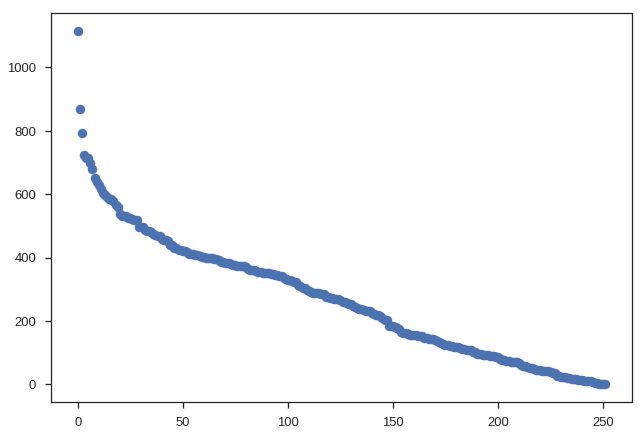

In [40]:
plt.scatter(np.arange(0, len(feat_imp)), feat_imp.imp)